In [1]:
import os
import math
import pickle
from argparse import Namespace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib

from eer import compute_eer
from osvm_auth import OSVMBase
from svm_auth import SVMBase

In [2]:
def make_attack_pool(cross_test_f, config):
    attack_pool = []
    for features in cross_test_f:
        assert config.n_cross_test <= features.shape[0]
        auth_f = features[config.n_enroll : config.n_enroll + config.n_auth]
        attack_pool.append(np.split(auth_f, config.auth_sessions))
    return attack_pool

def get_attack_sessions(sessions, i, config):
    sampler = np.random.choice(sessions.shape[0],
        config.auth_sessions * config.attack_data_ratio, replace=False)
    return sessions[sampler]

def make_df(method_names, method_results):
    stats = ("user_accept", "attack_accept", "std")
    index = pd.MultiIndex.from_product((method_names, stats), names=("name", "stat"))
    return pd.DataFrame(np.hstack(method_results), columns=index)

In [3]:
def eval_method(method_name, method_base, cross_test_f, attack_pool, config):
    result = []
    all_eers = []

    for i, features in enumerate(cross_test_f):
        enroll_f = features[:config.n_enroll]
        model_path = os.path.join("user_models", "%s-%d.pkl" % (method_name, i))
        
        if os.path.isfile(model_path):
            with open(model_path, "rb") as f:
                user_model = pickle.load(f)
        else:
            user_model = method_base.enroll(enroll_f)
            with open(model_path, "wb") as f:
                pickle.dump(user_model, f)
        
        user_auth_f = features[config.n_enroll : config.n_enroll + config.n_auth]
        user_sessions = np.array(np.split(user_auth_f, config.auth_sessions))
        user_scores = user_model.score_sessions(user_sessions)
        excl_sessions = np.concatenate(attack_pool[:i] + attack_pool[i + 1:])

        user_accepts, attack_accepts = [], []

        for _ in range(config.n_trials):
            attack_sessions = get_attack_sessions(excl_sessions, i, config)
            attack_scores = user_model.score_sessions(attack_sessions)

            eer_stats = compute_eer(user_scores, attack_scores,
                user_model.min_thresh, user_model.max_thresh, tol=1e-12)
            thresh, user_accept, attack_accept = eer_stats
            
            user_accepts.append(user_accept)
            attack_accepts.append(attack_accept)
        
        mean_user_accept = np.mean(user_accepts)
        mean_attack_accept = np.mean(attack_accepts)
        std = np.std(attack_accepts, ddof=1)
        all_eers.append(attack_accepts)

#         print(i, mean_user_accept, mean_attack_accept, std)

        result.append((mean_user_accept, mean_attack_accept, std))
    
    np.save("%s-eers.npy" % method_name, np.vstack(all_eers))

    return np.array(result)

In [4]:
config = Namespace()
config.__dict__.update({
    "debug" : False,
    "n_user" : "all",
    "relevance_factor" : 4,
    "n_enroll" : 500,
    "auth_window" : 10,
    "auth_sessions" : 50,
    "attack_data_ratio" : 5,
    "cohort_size" : 50,
    "n_cohort_enroll" : 250,
    "n_sess_per_impostor" : 10,
    "n_trials" : 40
})
config.n_auth = config.auth_sessions * config.auth_window
config.n_cross_test = config.n_enroll + config.auth_sessions * config.auth_window
config.n_cohort = config.n_cohort_enroll + config.n_sess_per_impostor * config.auth_window

In [5]:
# Features used for development phase
F_dev = np.load("data/F_dc_GaitNet_1534_4x100_67_78_80.npy") 
# Features used for enrollment and authentication phase
F_user = np.load("data/F_oak_GaitNet_1534_4x100_67_78_80.npy")
y_user = np.load("data/y_oaktech_highacc.npy")

In [6]:
users, counts = np.unique(y_user, return_counts=True)
F_user = [F_user[y_user == user] for user in users]

F_cross_test = [F_user[user] for user, count in zip(users, counts)
            if count >= config.n_cross_test]

if config.n_user is not "all":
    F_cross_test = F_cross_test[:config.n_user]

attack_pool = make_attack_pool(F_cross_test, config)

In [7]:
method_names = ["o-svm", "svm-nn"]
methods = [
    OSVMBase(F_dev),
    SVMBase(F_dev, None, n_neighbors=9, balanced=True, n_iter=12)
]

In [8]:
csv_file = "results.csv"

In [9]:
for method_name, method_base in zip(method_names, methods):
    result = eval_method(method_name, method_base, F_cross_test, attack_pool, config)
    eers = result[:, 1]

    method_names.append(method_name)
    method_results.append(result)

    df = make_df(method_names, method_results)
    df.to_csv("results.csv", index=False)

In [10]:
df = pd.read_csv(csv_file, header=[0, 1])
n_users = df.shape[0]

In [11]:
o_svm_eers = df["o-svm"]["attack_accept"].values
o_svm_stds = df["o-svm"]["std"].values
svm_nn_eers = df["svm-nn"]["attack_accept"].values
svm_nn_stds = df["svm-nn"]["std"].values

In [12]:
n_samples = 50
sampler = np.random.choice(n_users, size=n_samples, replace=False)

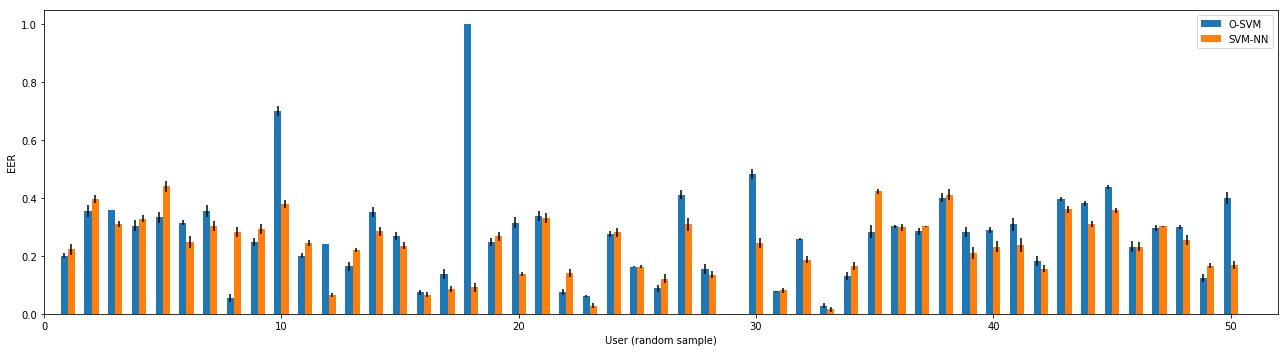

In [13]:
fig1 = plt.figure(1, figsize=(18, 5))
ax1 = fig1.gca()
ax1.bar(range(1, n_samples + 1), o_svm_eers[sampler], align="edge", yerr=o_svm_stds[sampler], width=-0.3, label="O-SVM")
ax1.bar(range(1, n_samples + 1), svm_nn_eers[sampler], align="edge", yerr=svm_nn_stds[sampler], width=0.3, label="SVM-NN")
ax1.set_xlabel("User (random sample)")
ax1.set_ylabel("EER")
ax1.set_xlim((0, n_samples + 2))
ax1.legend()
fig1.tight_layout()

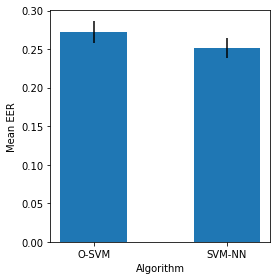

In [14]:
fig2 = plt.figure(2, figsize=(4, 4))
ax2 = fig2.gca()
ax2.bar(["O-SVM", "SVM-NN"], [np.mean(o_svm_eers), np.mean(svm_nn_eers)],
    yerr=[np.mean(o_svm_stds), np.mean(svm_nn_stds)], width=0.5)
ax2.set_xlabel("Algorithm")
ax2.set_ylabel("Mean EER")
fig2.tight_layout()

In [15]:
o_svm_eers = np.load("o-svm-eers.npy")
svm_nn_eers = np.load("svm-nn-eers.npy")

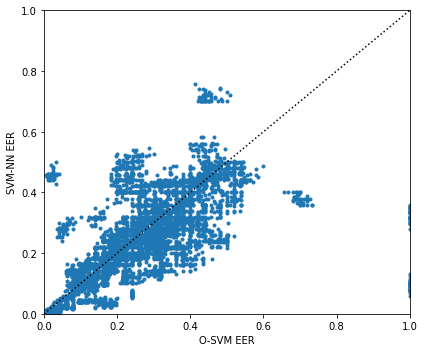

In [16]:
fig3 = plt.figure(3, figsize=(6, 5))
ax3 = fig3.gca()
ax3.plot(o_svm_eers.ravel(), svm_nn_eers.ravel(), ".")
ax3.plot((0, 1), (0, 1), "k:")
ax3.set_xlabel("O-SVM EER")
ax3.set_ylabel("SVM-NN EER")
ax3.set_xlim((0, 1))
ax3.set_ylim((0, 1))
fig3.tight_layout()